In [1]:
#!/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv
from scipy import optimize

### experiment design2 (Zupanski et al. 2008)

1.$ dx = 0.05, dt = 0.0125(= 45 sec), \nu = 0.05 $

2.number of points = 81, member = 4, number of observations = 81(all)

3.number of DA cycles = 20, interval between cycles = 15 minutes(= every 20 steps)

4-1.quadratic obs
$ H(x) = x^2 (x \ge 0.5) , -x^2 (x \lt 0.5) $

obs mean = 0.0, obs stdv = 8.0e-2, obs PDF = Gaussian

4-2.cubic obs
$ H(x) = x^3 (x \ge 0.5) , -x^3 (x \lt 0.5) $

obs mean = 0.0, obs stdv = 7.0e-4, obs PDF = Gaussian

5.initial state = begin forecast 2 cycles before TRUE

6.ensemble perturbation = lagged forecast (lag interval = ?)


In [2]:
# BURGERS MODEL
def l_operator(f, u, dx, nu):
# NB u is defined at integral index
# u[i-1/2] = (u[i-1] + u[i]) / 2
# u[i+1/2] = (u[i] + u[i+1]) / 2
# u[i+1/2] - u[i-1/2] = (u[i+1] - u[i-1]) / 2
    l = np.zeros_like(u)
    l[1:-1] = -0.5 * (f[2:] - f[0:-2]) / dx \
        + nu / dx**2 * (u[2:] - 2 * u[1:-1] + u[0:-2])
    return l


def step(u, dx, dt, nu):
    f = 0.5 * u**2
    u1 = u + dt * l_operator(f, u, dx, nu)
    return 0.5 * (u + u1 + dt * l_operator(f, u1, dx, nu))

In [155]:
def golden_section(x0,d0,*args):
    a0=-10
    b0=10
    t = 0.618 #golden_ratio
    a=a0
    b=b0
    c1=(a+b)/2-1
    c2=(a+b)/2+1
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    for k in range(1000):
        num+=1
        x1 = x0 + c1*d0
        f1 = J(x1,*args)
        x2 = x0 + c2*d0
        f2 = J(x2,*args)
        if(f2>f1):
            a=a
            b=c2
            c2_=c1
            c1_=a+(1-t)*(b-a)
        else:
            a=c1
            b=b
            c1_=c2
            c2_=b-(1-t)*(b-a)
        if(abs(b-a)<0.0001):
            #print(num,"end")
            break
        c1 = min(c1_,c2_)
        c2 = max(c1_,c2_)
        #print(num,a,b,c1,c2,abs(b-a))
    return a

def CG(x0,*args):
    d0 = -jacobi(x0,*args)
    jmin = -999
    for k in range(10000):
        alpha = golden_section(x0,d0,*args)
        x = x0 + alpha*d0
        d = jacobi(x,*args)
        if(np.sqrt(np.sum(d**2))<1e-7):
            print(k,"end")
            jmin = J(x,*args)
            print("current cost function value = {}".format(jmin))
            break
        p = -d + (np.dot(d.T,d)/np.dot(d0.T,d0))*d0
        x0 = x
        d0 = p
    return x, jmin

In [154]:
### MLEF code
def Analysis(Xfc,Xf,dXf,y,sig,m,N,a,mask,opt):
    #N = 40
    p = N-a
    R = np.eye(p)*sig*sig
    print(np.mean(np.diag(R)))
    I = np.eye(m)
    
    R_inv = np.linalg.inv(R)
    R_sqrt = np.sqrt(R_inv)
    z = R_sqrt@H_obs(Xf,mask,opt) - R_sqrt@H_obs(Xfc,mask,opt).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    C = z.T@z
    tmp = C[:,:]
    print(np.linalg.cond(tmp))
    #print(C)
    
    la,v = np.linalg.eigh(C)
    #print(v)
    D = np.diag(1/np.sqrt(la+np.ones(m)))
    #print(D)
    #V = np.array(v).reshape(m,m)
    A = v @ D @ v.T #(I+C)^(-1/2)
    
    zeta0 = np.zeros(m)
    args = (Xfc,dXf,A,y,R_inv,mask,opt)
    #res = optimize.minimize(J, zeta0, args=args, method='BFGS', jac=jacobi, options={'gtol':1e-8, 'disp':True})
    #zeta = res.x
    #jmin = res.fun
    #Pa_ = res.hess_inv #(I+C)^(-T/2)?
    zeta,jmin = CG(zeta0,*args)
    Xac = Xfc + dXf@A@zeta
    
    Xf = Xac.reshape(-1,1)+dXf
    z_opt = R_sqrt@H_obs(Xf,mask,opt) - R_sqrt@H_obs(Xac,mask,opt).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    C_opt = z_opt.T@z_opt
    
    la,v = np.linalg.eigh(C_opt)
    #print(v)
    D = np.diag(1/np.sqrt(la+np.ones(m)))
    #print(D)
    #V = np.array(v).reshape(m,m)
    A = v @ D @ v.T #(I+C_opt)^(-T/2)
    #print(A)
    
    # Chi^2 test
    # chi^2 = {R^(-1/2)[y-H(x)]}^TG^(-1){R^(-1/2)[y-H(x)]}/N_obs
    # G^(-1) = (I + ZZ^T)^(-1) = I - Z(I+Z^TZ)^(-1)Z^T = I - Z(I+C_opt)^(-1)Z^T
    G_inv = np.eye(p) - z_opt @ v @ np.diag(1/(la+np.ones(m))) @ v.T @ z_opt.T
    dep = y - H_obs(Xac,mask,opt)
    innv = R_sqrt@dep.reshape(-1,1)
    chi2 = innv.T @ G_inv @ innv / p
    
    dXa = dXf@A #Pf^(1/2)(I+C_opt)^(-T/2)
    
    Xa = np.zeros((N,m))
    Xa = dXa + Xac.reshape(-1,1)
    Pa = dXa@dXa.T
    
    return Xa,Pa,Xac,jmin,chi2[0]

def J(zeta,*args):
    xb,dXf,A,y,R_inv,mask,opt = args
    
    B = A.T@A #(I+C)^(-1)
     
    x = xb + dXf@A@zeta
    inv = y - H_obs(x,mask,opt)  
    return (zeta.T@B@zeta + inv.T@R_inv@inv)/2

def jacobi(zeta,*args):
    xb,dXf,A,y,R_inv,mask,opt = args
    B = A.T@A #(I+C)^(-1)
    R_sqrt = np.sqrt(R_inv)
    
    x = xb + dXf@A@zeta
    z = R_sqrt@H_obs(x.reshape(-1,1)+dXf,mask,opt) - R_sqrt@H_obs(x,mask,opt).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    inv = y - H_obs(x,mask,opt)
    ## modified
    djo = A.T@z.T@R_sqrt@inv
    #djo = z.T@R_sqrt@inv
    return B@zeta - djo

In [101]:
### GRAD code
def Analysis_G(Xfc,Xf,dXf,y,sig,m,N,a,mask,opt):
    #N = 40
    p = N-a
    R = np.eye(p)*sig*sig
    print(np.mean(np.diag(R)))
    I = np.eye(m)
    
    R_inv = np.linalg.inv(R)
    R_sqrt = np.sqrt(R_inv)
    #z = R_sqrt@H_t(Xfc,dXf,mask) #R^(-1/2)HPf^(1/2)
    #z = R_sqrt@H2_t(Xfc,dXf,mask)
    z = R_sqrt@Hobs_t(Xfc,dXf,mask,opt)
    C = z.T@z
    tmp = C[:,:]
    print(np.linalg.cond(tmp))
    #print(C)
    
    la,v = np.linalg.eigh(C)
    #print(v)
    D = np.diag(1/np.sqrt(la+np.ones(m)))
    #print(D)
    #V = np.array(v).reshape(m,m)
    A = v @ D @ v.T #(I+C)^(-T/2)
    
    zeta0 = np.zeros(m)
    args = (Xfc,dXf,A,y,R_inv,mask,opt)
    res = optimize.minimize(J_G, zeta0, args=args, method='BFGS', jac=jacobi_G, options={'gtol':1e-8, 'disp':True})
    zeta = res.x
    jmin = res.fun
    #Pa_ = res.hess_inv #(I+C)^(-T/2)?
    #zeta,jmin = CG(zeta0,*args)
    Xac = Xfc + dXf@A@zeta
    
    #Xf = Xac.reshape(-1,1)+dXf
    #z_opt = R_sqrt@H_t(Xac,dXf,mask) #R^(-1/2)HPf^(1/2)
    #z_opt = R_sqrt@H2_t(Xac,dXf,mask)
    z_opt = R_sqrt@Hobs_t(Xac,dXf,mask,opt)
    C_opt = z_opt.T@z_opt
    
    la,v = np.linalg.eigh(C_opt)
    #print(v)
    D = np.diag(1/np.sqrt(la+np.ones(m)))
    #print(D)
    #V = np.array(v).reshape(m,m)
    A = v @ D @ v.T #(I+C_opt)^(-T/2)
    #print(A)
    
    # Chi^2 test
    # chi^2 = {R^(-1/2)[y-H(x)]}^TG^(-1){R^(-1/2)[y-H(x)]}/N_obs
    # G^(-1) = (I + ZZ^T)^(-1) = I - Z(I+Z^TZ)^(-1)Z^T = I - Z(I+C_opt)^(-1)Z^T
    G_inv = np.eye(p) - z_opt @ v @ np.diag(1/(la+np.ones(m))) @ v.T @ z_opt.T
    dep = y - H_obs(Xac,mask,opt)
    innv = R_sqrt@dep.reshape(-1,1)
    chi2 = innv.T @ G_inv @ innv / p
    
    dXa = dXf@A #Pf^(1/2)(I+C_opt)^(-T/2)
    
    Xa = np.zeros((N,m))
    Xa = dXa + Xac.reshape(-1,1)
    Pa = dXa@dXa.T
    
    return Xa,Pa,Xac,jmin,chi2[0]

def J_G(zeta,*args):
    xb,dXf,A,y,R_inv,mask,opt = args
    B = A.T@A #(I+C)^(-1)
     
    x = xb + dXf@A@zeta
    inv = y - H_obs(x,mask,opt)   
    return (zeta.T@B@zeta + inv.T@R_inv@inv)/2

def jacobi_G(zeta,*args):
    xb,dXf,A,y,R_inv,mask,opt = args
    B = A.T@A #(I+C)^(-1)
    R_sqrt = np.sqrt(R_inv)
    
    x = xb + dXf@A@zeta
    #z = R_sqrt@H_obs(x.reshape(-1,1)+dXf,mask) - R_sqrt@H_obs(x,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    z = R_sqrt@Hobs_t(x,dXf,mask,opt) #R^(-1/2)(dH/dx)Pf^(1/2)
    inv = y - H_obs(x,mask,opt)
    ##modified
    djo = A.T@z.T@R_sqrt@inv
    #djo = z.T@R_sqrt@inv
    return B@zeta - djo

In [122]:
def H_obs(x,mask,opt):
    
    xo = np.delete(x,mask,axis=0)
    sign = np.ones(xo.shape)
    sign[xo<0.5] = -1
    if(opt==0):
    ## y = x
        y = xo
    elif (opt==1):
    ## y = x^2
        y = xo**2
    elif (opt==2):
    ## y = x^3
        y = xo**3
    elif (opt==3):
    ## y = x^2 or -x^2
        y = sign * (xo**2)
    elif (opt==4):
    ## y = x^3 or -x^3
        y = sign * (xo**3)
        
    return y

def Hobs_t(x,dx,mask,opt):
    xo = np.delete(x,mask,axis=0)
    dxo = np.delete(dx,mask,axis=0)
    sign = np.ones(xo.shape)
    sign[xo<0.5] = -1
    if(opt==0):
    ## y = x
        y = dxo
    elif (opt==1):
    ## y = x^2
        y = 2.0*xo.reshape(-1,1)*dxo
    elif (opt==2):
    ## y = x^3
        y = 3.0*(xo*xo).reshape(-1,1)*dxo
    elif (opt==3):
    ## y = x^2 or -x^2
        y = 2.0*(sign*xo).reshape(-1,1)*dxo
    elif (opt==4):
    ## y = x^3 or -x^3
        y = 3.0*(sign*xo*xo).reshape(-1,1)*dxo
        
    return y

In [123]:
init_obs = False
xi = np.array([0.4])
p = np.array([1.0])
mask = np.random.choice(1,0,replace=False)
print(H_obs(xi+p,mask,4)-H_obs(xi,mask,4))
print(Hobs_t(xi,p,mask,4))
print(1.4**3+0.4**3)
print(init_obs)

[2.808]
[[-0.48]]
2.8079999999999994
False


In [105]:
def initialize(opt):
    global u0, x, jmax, xmax, dx, dt, nu, dt_sec, obs_m, obs_s, obs_opt, obstype
    
    jmax = 81
    xmax = 2.0
    dx = 0.05
    dt = 0.0125
    dt_sec = dt*3600.0
    nu = 0.05
    x = np.arange(jmax)*dx - xmax
    u0 = np.zeros(jmax)
    u0[0] = 1.0
    dum = np.zeros(jmax)
    obs_opt = opt
    
    obs_m = 0.0
    if(opt==0): # y=x
        obs_s = 1.0e-1
    elif(opt==1 or opt==3): # y=x^2
        obs_s = 8.0e-2
    elif(opt==2 or opt==4): # y=x^3
        obs_s = 7.0e-4
    
    # initial state
    for k in range(40):
        dum = step(u0, dx, dt, nu)
        u0 = dum[:]
    plt.plot(x,u0)
    plt.title("initial state")
    plt.show()
    print("nx={} nu={} dx={:7.3e} dt={:7.3e} dt_sec={:7.3e}".format(jmax, nu, dx, dt, dt_sec))
    obstype = ['unit','quad','cubic','quad_nonlinear','cubic_nonlinear']
    print(obstype[obs_opt])

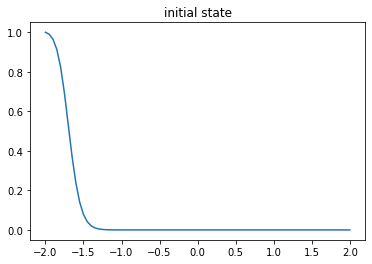

nx=81 nu=0.05 dx=5.000e-02 dt=1.250e-02 dt_sec=4.500e+01
quad
Number of DA cycles = 20cycles, cycle interval = 15.0min., each cycle steps = 20steps
Number of observations = 81, observation option = 1
fcst length = 400, incr_dt = 900.0sec.
[1.00000000e+00 9.89551766e-01 9.64332152e-01 9.12943022e-01
 8.23325101e-01 6.91853561e-01 5.32260231e-01 3.72328806e-01
 2.38035879e-01 1.40890357e-01 7.83472428e-02 4.14353201e-02
 2.10152930e-02 1.02718782e-02 4.85097001e-03 2.21608022e-03
 9.79758666e-04 4.19259099e-04 1.73649699e-04 6.96116177e-05
 2.70085830e-05 1.01424872e-05 3.68666563e-06 1.29719399e-06
 4.41876940e-07 1.45737479e-07 4.65441501e-08 1.43957113e-08
 4.31244332e-09 1.25135399e-09 3.51756866e-10 9.57951224e-11
 2.52759881e-11 6.46181058e-12 1.60062718e-12 3.84162579e-13
 8.93341931e-14 2.01268732e-14 4.39296400e-15 9.28788040e-16
 1.90193457e-16 3.77158299e-17 7.24129363e-18 1.34577859e-18
 2.42036625e-19 4.21121240e-20 7.08602738e-21 1.15265789e-21
 1.81180797e-22 2.75060762e-2

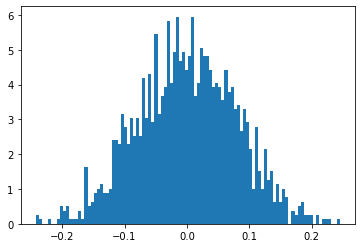

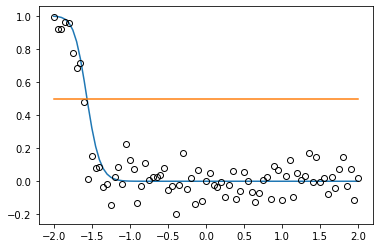

obs mean=0.002694132493038582, obs stdv=0.00733739628444048


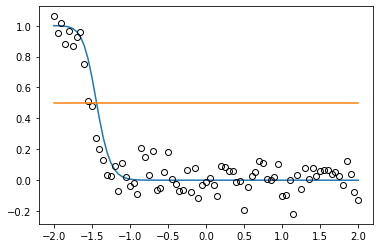

obs mean=0.009466616190593528, obs stdv=0.006445649364313585


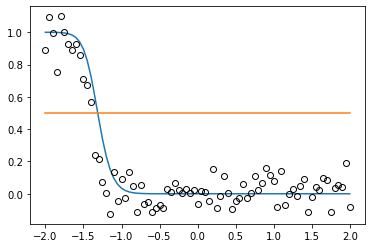

obs mean=0.002364698621397642, obs stdv=0.006489972149623698


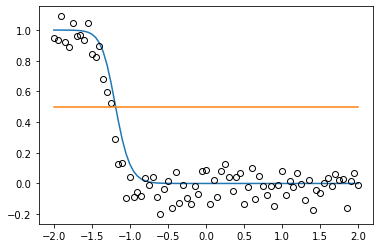

obs mean=-0.021629968660940545, obs stdv=0.005712329130696031


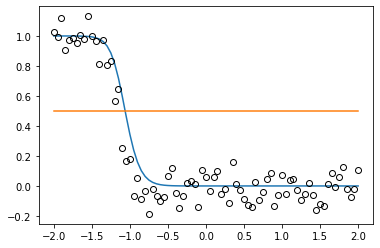

obs mean=-0.01802239349051019, obs stdv=0.006569609363885348


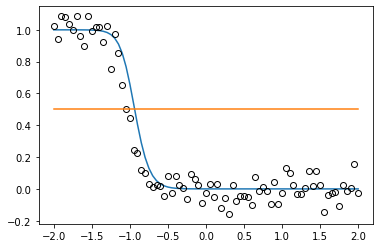

obs mean=-0.0014009169643146046, obs stdv=0.0046628817346032626


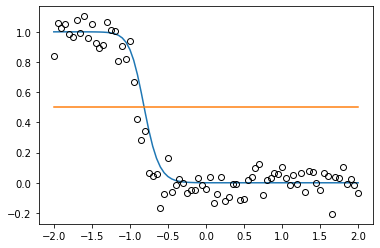

obs mean=-0.004738412151228668, obs stdv=0.005778073400218087


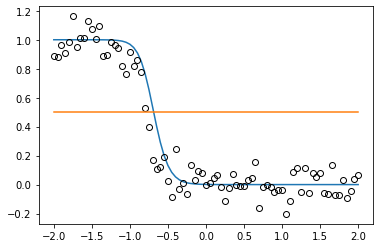

obs mean=-0.004689631872090912, obs stdv=0.0074085838541365825


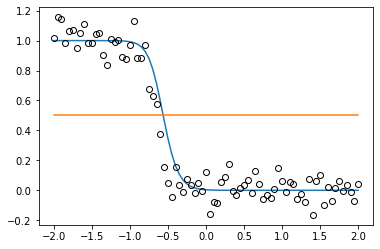

obs mean=0.0077785450332640066, obs stdv=0.00593806837230229


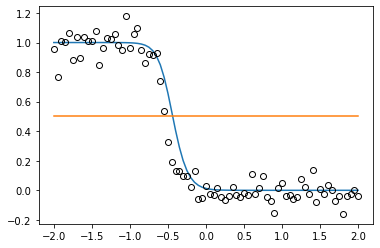

obs mean=-0.009406011544655372, obs stdv=0.004921388751442844


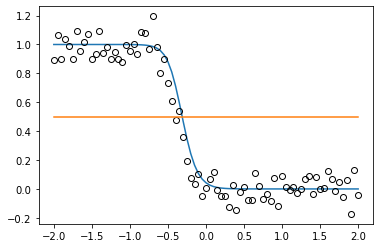

obs mean=-0.00015464634216109246, obs stdv=0.006322011351754815


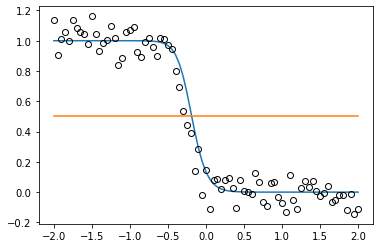

obs mean=0.007065792695339114, obs stdv=0.006021972759273728


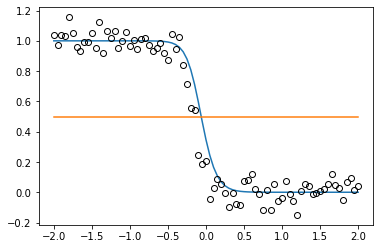

obs mean=0.0020174869424245878, obs stdv=0.004229856936825602


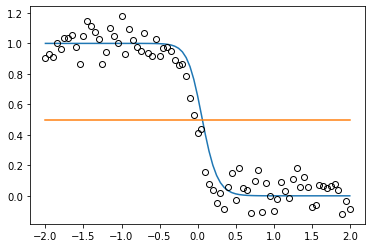

obs mean=0.008903451985104642, obs stdv=0.00649496545172145


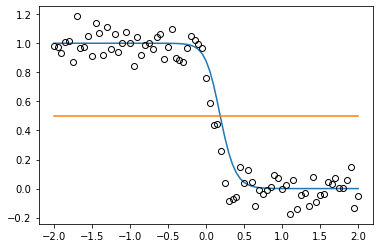

obs mean=-0.005719022042384407, obs stdv=0.006613856545513612


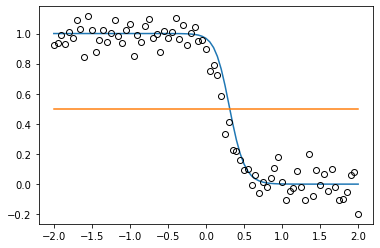

obs mean=0.0006311000826218034, obs stdv=0.00628891394538765


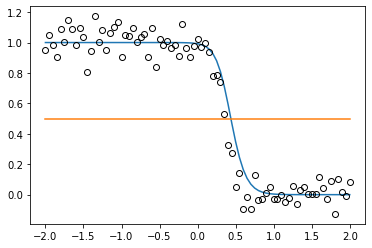

obs mean=0.009680470811085777, obs stdv=0.005284411428037574


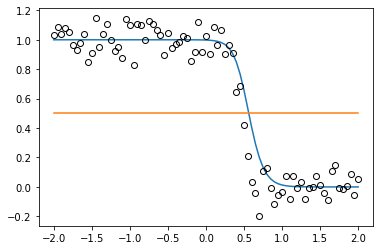

obs mean=0.003223040328682615, obs stdv=0.007235652735173152


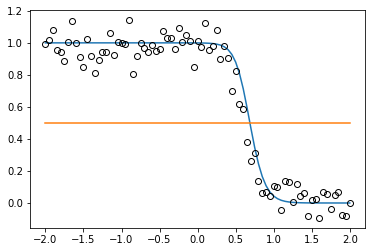

obs mean=0.0018416194795636395, obs stdv=0.006225139745302997


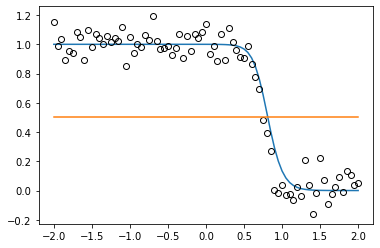

obs mean=0.018942894726264994, obs stdv=0.006202685312702934


In [151]:
### true state and obs
initialize(opt=1)
N_cycles = 20
cycle_int = 15.0 #minutes
N_steps = int(cycle_int * 60. / dt_sec)
N_obs = jmax
print("Number of DA cycles = {}cycles, cycle interval = {}min., each cycle steps = {}steps"
      .format(N_cycles, cycle_int, N_steps))
print("Number of observations = {}, observation option = {}".format(N_obs, obs_opt))

yo = np.zeros((N_cycles,N_obs)) # observation
mask = np.random.choice(jmax,jmax-N_obs,replace=False) # obsmiss

## true
fcst_length = N_steps * N_cycles
incr_dt = cycle_int * 60.
print("fcst length = {}, incr_dt = {}sec.".format(fcst_length, incr_dt))
ut = np.zeros((fcst_length+1,jmax))
# initialize
ut[0] = u0[:]

#plt.plot(x,ut[0])
print(ut[0])
line = np.ones(x.size)*0.5
i = 0
for k in range(1,fcst_length+1):
    ut[k] = step(ut[k-1], dx, dt, nu)
    if (k%N_steps==0):
        yo[i] = H_obs(ut[k],mask,obs_opt)
        i += 1
        print("cycle{}".format(int(k/N_steps)))
        #print(ut[k])
#plt.title("true state")
#plt.show()

## observation
#obs_m = obs_m3
#obs_s = obs_s3
print(obs_m, obs_s)
err = [random.normalvariate(obs_m, obs_s) for k in range(yo.size)]
oberr = np.array(err).reshape(yo.shape)
plt.hist(err,bins=100,density=True)
plt.show()
yo += oberr
for k in range(N_cycles):
    d = yo[k] - H_obs(ut[int((k+1)*N_steps)],mask,obs_opt)
    plt.plot(x,ut[int((k+1)*N_steps)])
    plt.plot(x,yo[k],"ko",markerfacecolor="none")
    plt.plot(x,line)
    plt.show()
        
    #print(d)
    print("obs mean={}, obs stdv={}".format(np.mean(d), np.mean((d - np.mean(d))**2)))

fcst length = 440, incr_dt = 900.0sec.
cycle1
[1.00000000e+00 9.99908672e-01 9.99678314e-01 9.99157250e-01
 9.98051136e-01 9.95805034e-01 9.91400100e-01 9.83026413e-01
 9.67619580e-01 9.40383346e-01 8.94776989e-01 8.23951650e-01
 7.24436924e-01 6.00695742e-01 4.66282606e-01 3.38772611e-01
 2.31882720e-01 1.51101835e-01 9.47838206e-02 5.77806019e-02
 3.44713147e-02 2.02200479e-02 1.16944707e-02 6.67926742e-03
 3.77007931e-03 2.10356506e-03 1.16020226e-03 6.32422591e-04
 3.40619995e-04 1.81219503e-04 9.52129056e-05 4.93894301e-05
 2.52883700e-05 1.27781734e-05 6.37091153e-06 3.13367352e-06
 1.52044191e-06 7.27618146e-07 3.43413036e-07 1.59837608e-07
 7.33611398e-08 3.32016670e-08 1.48165608e-08 6.51958794e-09
 2.82861351e-09 1.21005966e-09 5.10412945e-10 2.12286778e-10
 8.70597634e-11 3.52057942e-11 1.40385885e-11 5.52023136e-12
 2.14056655e-12 8.18562506e-13 3.08703424e-13 1.14818792e-13
 4.21194169e-14 1.52393288e-14 5.43850998e-15 1.91443770e-15
 6.64762339e-16 2.27704719e-16 7.694396

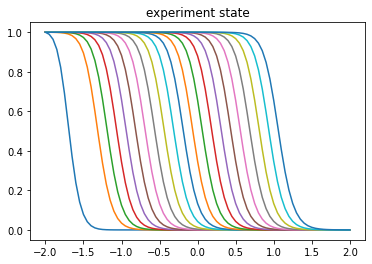

rmse no-obs
[0.16788967 0.16248934 0.15956811 0.15784898 0.15678619 0.15610811
 0.1556661  0.15537353 0.15517768 0.15504544 0.15495555 0.15489411
 0.15485193 0.15482286 0.15480277 0.15478885 0.15477917 0.15477244
 0.15476774 0.15476446 0.15476215]


In [18]:
### No-observation experiment
N_cycle_shift = 2 #initial condition lag
fcst_length = N_steps * ( N_cycles + N_cycle_shift )
incr_dt = cycle_int * 60.

print("fcst length = {}, incr_dt = {}sec.".format(fcst_length, incr_dt))
un = np.zeros((fcst_length+1,jmax))
# initialize
un[0] = u0[:]
plt.plot(x,un[0])
for k in range(1,fcst_length+1):
    un[k] = step(un[k-1], dx, dt, nu)
    if (k/N_steps>N_cycle_shift and k%N_steps==0):
        plt.plot(x,un[k])
        print("cycle{}".format(int(k/N_steps-N_cycle_shift)))
        print(un[k])
plt.title("experiment state")
plt.show()

rmsen = np.zeros(N_cycles+1)
for i in range(N_cycles+1):
    ind_n = (i+N_cycle_shift)*N_steps
    ind_t = i*N_steps
    rmsen[i] = np.mean((un[ind_n]-ut[ind_t])**2)
rmsen = np.sqrt(rmsen)
print("rmse no-obs")
print(rmsen)

In [10]:
### ensemble initialize
def init_ens():
    global mem, uc0, ue0, sqrtPa0
    mem = 4 # ensemble size
    lag = int(N_steps/2)

    ## control
    t_cntrl = N_cycle_shift * N_steps
    uc0 = np.zeros(jmax)
    uc0 = un[t_cntrl,:]
    #plt.plot(x,uc0)
    ue0 = np.zeros((jmax,mem))
    for imem in range(int(mem/2)):
        t_mem = t_cntrl - lag*(imem+1)
        ue0[:,2*imem] = un[t_mem,:]
        t_mem = t_cntrl + lag*(imem+1)
        ue0[:,2*imem+1] = un[t_mem,:]
    #for imem in range(mem):
    #    plt.plot(x,ue0[:,imem])
    #plt.title("ensemble state")
    #plt.show()
    sqrtPa0 = (ue0 - uc0.reshape(-1,1))#/np.sqrt(2.0*(mem-1))
    print("ensemble initialized")
    #print(sqrtPa0)

fcst length = 400, incr_dt = 900.0sec., obs miss = 0
ensemble initialized
cycle0
0.006400000000000001
18086.261246144517
cycle1
0.006400000000000001
23991.98998849158
cycle2
0.006400000000000001
104754.18715059638
cycle3
0.006400000000000001
370365.82754295494
cycle4
0.006400000000000001
1201991.2828668843
cycle5
0.006400000000000001
3480001.5351520455
cycle6
0.006400000000000001
9585935.242936008
cycle7
0.006400000000000001
24617445.42482082
cycle8
0.006400000000000001
58292712.15041334
cycle9
0.006400000000000001
132116511.39577463
cycle10
0.006400000000000001
279568530.9745391
cycle11
0.006400000000000001
579658517.2699106
cycle12
0.006400000000000001
1131999272.9642797
cycle13
0.006400000000000001
2147648786.085476
cycle14
0.006400000000000001
4115468887.0757875
cycle15
0.006400000000000001
7898408015.685799
cycle16
0.006400000000000001
15261512364.28603
cycle17
0.006400000000000001
29683082540.659126
cycle18
0.006400000000000001
58329684273.609085
cycle19
0.006400000000000001
1184

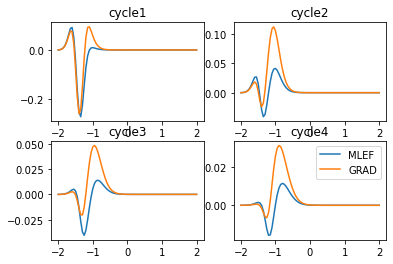

[array([1.20141208]), array([1.04524356]), array([1.00328767]), array([0.97238301]), array([1.07341972]), array([0.72460844]), array([0.90666486]), array([1.1495791]), array([0.93606288]), array([0.77545059]), array([0.98704576]), array([0.94749912]), array([0.65686364]), array([1.02518794]), array([1.03818802]), array([0.98315431]), array([0.84087172]), array([1.13037698]), array([0.97239914]), array([1.01494111])]


In [156]:
### assimilation
fcst_length = N_cycles * N_steps
obsmiss = jmax - N_obs
print("fcst length = {}, incr_dt = {}sec., obs miss = {}".format(fcst_length, incr_dt, obsmiss))

## MLEF
##initialize
init_ens()
ua = np.zeros((fcst_length+1,jmax)) # analysis, control
uf = np.zeros((fcst_length+1,jmax)) # forecast, control
ue = np.zeros((jmax,mem)) # ensemble(analysis)
uef = np.zeros((jmax,mem)) # ensemble(forecast)
ua[0] = uc0[:]
uf[0] = uc0[:]
ue = ue0[:,:]
trPa = []
Jmin_m = []
Chi_m = []
P0 = sqrtPa0@sqrtPa0.T
trPa.append(np.mean(np.diag(P0)))
for k in range(1,fcst_length+1):
    # forecast
    uf[k] = step(ua[k-1], dx, dt, nu)
    for imem in range(mem):
        uef[:,imem] = step(ue[:,imem], dx, dt, nu)
    sqrtPf = np.zeros(uef.shape)
    sqrtPf = uef - uf[k].reshape(-1,1)#/np.sqrt(mem-1)
    #sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(2.0*(mem-1))
    if(k%N_steps==0):
    # analysis
        k_obs = int(k/N_steps) - 1
        print("cycle"+str(k_obs))
        mask = np.random.choice(jmax,obsmiss,replace=False)
        (ue, Pa, ua[k], jmin, chi2) = Analysis(uf[k], uef, sqrtPf, yo[k_obs], obs_s, mem, jmax, obsmiss, mask, obs_opt)
        trPa.append(np.mean(np.diag(Pa)))
        Jmin_m.append(jmin)
        Chi_m.append(chi2)
    else:
        ua[k] = uf[k]
        ue = uef[:,:]

rmsea = np.zeros(N_cycles)
for i in range(1,N_cycles+1):
    ind_a = i*N_steps
    ind_t = i*N_steps
    rmsea[i-1] = np.mean((ua[ind_a]-ut[ind_t])**2)
rmsea = np.sqrt(rmsea)

fig = plt.figure()
ax = []
for i in range(1,5):
    ind_a = i*N_steps
    ind_t = i*N_steps
    ax.append(fig.add_subplot(2, 2, i, title="cycle"+str(i)))
    ax[i-1].plot(x, ua[ind_a]-ut[ind_t],label="MLEF")


## GRAD
##initialize
init_ens()
ua = np.zeros((fcst_length+1,jmax)) # analysis, control
uf = np.zeros((fcst_length+1,jmax)) # forecast, control
ue = np.zeros((jmax,mem)) # ensemble(analysis)
uef = np.zeros((jmax,mem)) # ensemble(forecast)
ua[0] = uc0[:]
uf[0] = uc0[:]
ue = ue0[:,:]
trPa = []
Jmin_g = []
Chi_g = []
P0 = sqrtPa0@sqrtPa0.T
trPa.append(np.mean(np.diag(P0)))
for k in range(1,fcst_length+1):
    # forecast
    uf[k] = step(ua[k-1], dx, dt, nu)
    for imem in range(mem):
        uef[:,imem] = step(ue[:,imem], dx, dt, nu)
    sqrtPf = np.zeros(uef.shape)
    sqrtPf = (uef - uf[k].reshape(-1,1))#/np.sqrt(mem-1)
    #sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(2.0*(mem-1))
    if(k%N_steps==0):
    # analysis
        k_obs = int(k/N_steps) - 1
        print("cycle"+str(k_obs))
        mask = np.random.choice(jmax,obsmiss,replace=False)
        (ue, Pa, ua[k], jmin, chi2) = Analysis_G(uf[k], uef, sqrtPf, yo[k_obs], obs_s, mem, jmax, obsmiss, mask, obs_opt)
        trPa.append(np.mean(np.diag(Pa)))
        Jmin_g.append(jmin)
        Chi_g.append(chi2)
    else:
        ua[k] = uf[k]
        ue = uef[:,:]
rmseg = np.zeros(N_cycles)
for i in range(1,N_cycles+1):
    ind_a = i*N_steps
    ind_t = i*N_steps
    rmseg[i-1] = np.mean((ua[ind_a]-ut[ind_t])**2)
rmseg = np.sqrt(rmseg)

for i in range(1,5):
    ind_a = i*N_steps
    ind_t = i*N_steps
    ax[i-1].plot(x, ua[ind_a]-ut[ind_t],label="GRAD")
    
print("rmse MLEF")
print(rmsea)

print("rmse GRAD")
print(rmseg)

plt.legend()
plt.savefig("anl_err_"+obstype[obs_opt]+".png")
plt.show()

print(Chi_m)
#print("error covariance")
#print(trPa)

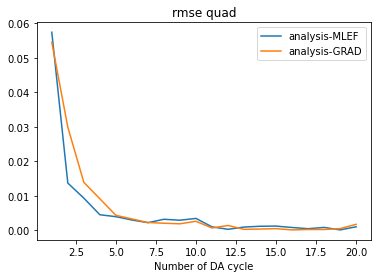

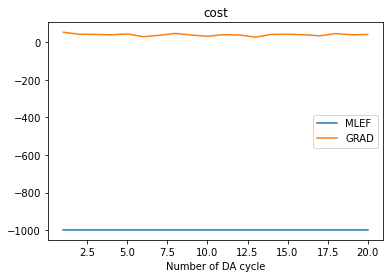

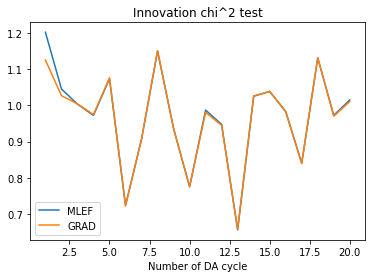

In [157]:
DAcycle = np.arange(1,N_cycles+1)
#plt.plot(DAcycle,rmsen[1:],label="no-obs")
plt.plot(DAcycle,rmsea,label="analysis-MLEF")
plt.plot(DAcycle,rmseg,label="analysis-GRAD")
#plt.plot(DAcycle,rmsef,label="background")
#plt.plot(DAcycle,trPa[1:],label="trPa")
plt.xlabel("Number of DA cycle")
plt.title("rmse "+obstype[obs_opt])
plt.legend()
plt.savefig("rmse-BURGERS-mlef-grad_"+obstype[obs_opt]+".png")
plt.show()

DAcycle = np.arange(1,N_cycles+1)
plt.plot(DAcycle,Jmin_m,label="MLEF")
plt.plot(DAcycle,Jmin_g,label="GRAD")
plt.xlabel("Number of DA cycle")
plt.title("cost")
plt.legend()
plt.savefig("cost-BURGERS-mlef-grad_"+obstype[obs_opt]+".png")
plt.show()

DAcycle = np.arange(1,N_cycles+1)
plt.plot(DAcycle,Chi_m,label="MLEF")
plt.plot(DAcycle,Chi_g,label="GRAD")
plt.xlabel("Number of DA cycle")
plt.title("Innovation chi^2 test")
plt.legend()
plt.savefig("chi2-BURGERS-mlef-grad_"+obstype[obs_opt]+".png")
plt.show()